### Installations and Imports

In [1]:
!pip install ucimlrepo
!pip install aif360

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.8/229.8 kB 4.4 MB/s eta 0:00:00


In [2]:
import sys
import numpy as np
import pandas as pd

import ucimlrepo

from aif360.datasets import AdultDataset, GermanDataset, CompasDataset, BinaryLabelDataset

from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.metrics.utils import compute_boolean_conditioning_vector

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions\
                import load_preproc_data_adult, load_preproc_data_compas

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm


pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


### Data Exploration and Preprocessing

In [3]:
# fetch dataset
adult = ucimlrepo.fetch_ucirepo(id=2)

df = adult.data.features
y = adult.data.targets
df = df.join(y)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             48842 non-null  int64 
 1   workclass       47879 non-null  object
 2   fnlwgt          48842 non-null  int64 
 3   education       48842 non-null  object
 4   education-num   48842 non-null  int64 
 5   marital-status  48842 non-null  object
 6   occupation      47876 non-null  object
 7   relationship    48842 non-null  object
 8   race            48842 non-null  object
 9   sex             48842 non-null  object
 10  capital-gain    48842 non-null  int64 
 11  capital-loss    48842 non-null  int64 
 12  hours-per-week  48842 non-null  int64 
 13  native-country  48568 non-null  object
 14  income          48842 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.6+ MB


Handling null values in the data. Some null values are identified by `'?'` which we need to change.

In [5]:
df[df == '?'] = np.nan
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45222 entries, 0 to 48841
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             45222 non-null  int64 
 1   workclass       45222 non-null  object
 2   fnlwgt          45222 non-null  int64 
 3   education       45222 non-null  object
 4   education-num   45222 non-null  int64 
 5   marital-status  45222 non-null  object
 6   occupation      45222 non-null  object
 7   relationship    45222 non-null  object
 8   race            45222 non-null  object
 9   sex             45222 non-null  object
 10  capital-gain    45222 non-null  int64 
 11  capital-loss    45222 non-null  int64 
 12  hours-per-week  45222 non-null  int64 
 13  native-country  45222 non-null  object
 14  income          45222 non-null  object
dtypes: int64(6), object(9)
memory usage: 5.5+ MB


In [6]:
df['race'].replace(['Black', 'Asian-Pac-Islander', 'Amer-Indian-Eskimo', 'Other'],'Non-White', inplace = True)

df = df.replace({"<=50K.":"<=50K", ">50K.":">50K"})
df['income']=df['income'].map({'<=50K': 0, '>50K': 1})
df.drop(['education'], axis = 1, inplace = True)

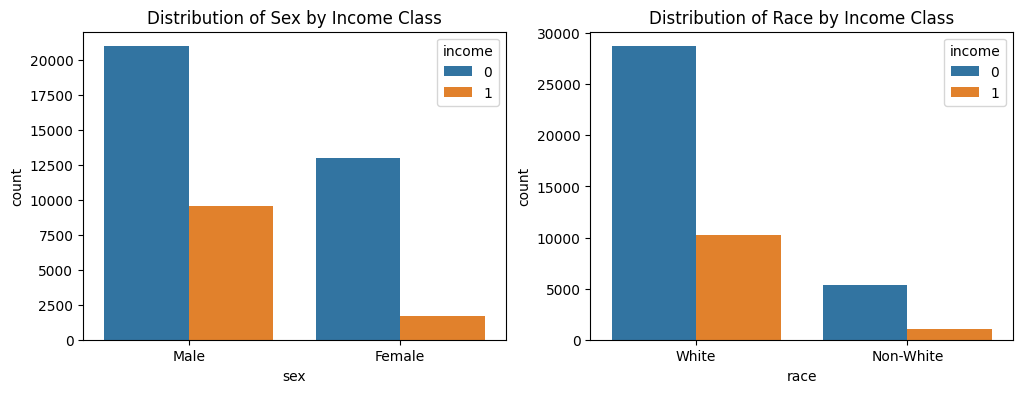

In [ ]:
# @title
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot distribution of sex by income class
sns.countplot(x='sex', hue='income', data=df, ax=axes[0])
axes[0].set_title('Distribution of Sex by Income Class')

# Plot distribution of race by income class
sns.countplot(x='race', hue='income', data=df, ax=axes[1])
axes[1].set_title('Distribution of Race by Income Class')

plt.show()


In [ ]:
# @title
# Number of columns in the dataframe excluding the 'income' column
num_columns = len(df.columns) - 1

# Number of rows and columns for the subplots
num_rows = (num_columns + 2) // 3  # Add 2 to ensure that there are enough rows for all subplots
num_cols = 3

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 3))

# Flatten the axes array for easier indexing
axes = axes.flatten()

# Iterate over the columns and plot each one in a separate subplot
for i, column in enumerate(df.columns[:-1]):  # Exclude the 'income' column
    ax = axes[i]
    if df[column].dtype == 'object':
        sns.countplot(x=column, hue='income', data=df, ax=ax)
    else:
        sns.histplot(df, x=column, hue='income', bins=20, kde=True, stat='density', ax=ax)
    ax.set_title(f"Distribution of {column} by Income Class")
    ax.tick_params(axis='x', rotation=45)

# Hide any unused subplots
for j in range(i + 1, num_rows * num_cols):
    axes[j].axis('off')

# Adjust the layout and show the plot
plt.tight_layout()
plt.show()


In [7]:
df['sex'] = df['sex'].map({'Male': 1, 'Female': 0})
df['race'] = df['race'].map({'White': 1, 'Non-White': 0})

one-hot encoding the categorical variables

In [8]:
df_encoded = pd.get_dummies(df, columns=df.select_dtypes(include=['object']).columns)
df_encoded.head()

,age,fnlwgt,education-num,race,sex,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,1,1,2174,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,1,1,0,0,13,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,1,1,0,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,0,1,0,0,40,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,0,40,0,0,...,0,0,0,0,0,0,0,0,0,0


**Development Set Splits and Scaling**

Split Data into Training (70%), Validation (15%), Test (15%) stratified based on **sex, race, and income** to maintain the proportions in the original dataset.

In [9]:
# Split the combined DataFrame into train and test sets, stratifying on sex and race
df_train, df_test = train_test_split(df_encoded, test_size=0.3, stratify=df_encoded[['sex', 'race','income']], random_state=42)

# Split the train set into train and validation sets, stratifying on sex and race
df_test, df_val = train_test_split(df_test, test_size=0.5, stratify=df_test[['sex', 'race','income']], random_state=42)


### Exploring Biases in the Data

The sensitive attributes in this dataset are race and sex. **For this tutorial, we focus on the biases against sex.**

According to the distribution of incomes for females and males:
*   Privileged group: Males
*   Unprivileged group: Females



We are using **AIF360** library for exploring biases.

We need to convert dataframes to it's acceptable format `BinaryLabelDataset`.

In [10]:
# Define the name of the target label column
label_name = 'income'  # Change this to the name of your label column

# Define the names of the sensitive attribute columns
sensitive_attributes = ['race', 'sex']  # Change this to your sensitive attribute columns

train_bld = BinaryLabelDataset(df=df_train, label_names=[label_name],protected_attribute_names=sensitive_attributes)
valid_bld = BinaryLabelDataset(df=df_val, label_names=[label_name],protected_attribute_names=sensitive_attributes)
test_bld = BinaryLabelDataset(df=df_test, label_names=[label_name],protected_attribute_names=sensitive_attributes)

Fairness can be evaluated in different stages of machine learning pipeline, either on the training data or on the learned model.

Here we look at the difference in mean outcomes difference/ Statistical Parity Difference between unprivileged and privileged groups (females vs males).

Statistical Parity Difference (SPD) is defined as:

$$
\text{SPD} = P(\hat{Y} = 1 | D = \text{unprivileged}) - P(\hat{Y} = 1 | D = \text{privileged})
$$
where:

- $\hat{Y} = 1$ indicates a positive outcome (e.g., having >50k income).
- $D = \text{unprivileged}$ indicates membership in the unprivileged group.
- $D = \text{privileged}$ indicates membership in the privileged group.

Ideal value for $SPD$ is zero. $SPD < 0$ indicates that unprivileged group has a lower rate of positive outcomes.

For metrics on Data we use `BinaryLabelDatasetMetric`.

In [11]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

DM_train_org = BinaryLabelDatasetMetric(train_bld,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Train Set: Difference in mean outcomes between unprivileged and privileged groups = %f" % DM_train_org.mean_difference())


DM_valid_org = BinaryLabelDatasetMetric(valid_bld,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Valid Set: Difference in mean outcomes between unprivileged and privileged groups = %f" % DM_valid_org.mean_difference())


DM_test_org = BinaryLabelDatasetMetric(test_bld,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)
print("Test Set: Difference in mean outcomes between unprivileged and privileged groups = %f" % DM_test_org.mean_difference())

Train Set: Difference in mean outcomes between unprivileged and privileged groups = -0.198935
Valid Set: Difference in mean outcomes between unprivileged and privileged groups = -0.199015
Test Set: Difference in mean outcomes between unprivileged and privileged groups = -0.198630


The $SPD$ results suggest that the unprivileged group has consistently lower rate of positive incomes in all sets.

## Fairness Evaluation
### Choose Appropriate Fairness Metrics:
Define what fairness means in the context of predicting income levels.

* Does it mean that men and women should be classified as earning more than $50K at equal rates when they actually do (equality of opportunity)?
* Should the overall rates of prediction be equal regardless of the base rates (demographic parity)?

> *Other consideration in real-world*: Legal and ethical considerations, different stakeholders perspectives and needs, how bias impacts both unprivileged and privileged groups?




***If a woman and a man have the same qualifications and contribute similarly to their roles, it is fair for a model to predict their income levels similarly.***

#### **Equality of Opportunity:**
 ideal value is zero. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group. Fairness range for this metric is $[-0.1, 0.1]$.


$${TPR}_{D = unprivileged} - {TPR}_{D = privileged}$$
<!-- $$ TPR = \frac{TP}{P} $$ -->


#### **Average Odds Difference**:
 ideally zero. A value of < 0 implies higher benefit for the privileged group and a value > 0 implies higher benefit for the unprivileged group. Fairness range for this metric is $[-0.1, 0.1]$.

$$ \frac{1}{2}[({FPR}_{D = unprivileged} - {FPR}_{D = privileged}) + ({TPR}_{D = unprivileged} - {TPR}_{D = privileged})]$$

#### **Balanced Accuracy**:

$$
\frac{{TPR} + {TNR}}{2}
$$

##Train initial model with original data



In [12]:
import torch

import torch # pytorch main library
import torchvision # computer vision utilities
import torchvision.transforms as transforms # transforms used in the pre-processing of the data

from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

####Using MinMaxScaler to trasnform data into [0,1] range.



In [13]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train_bld.features)
y_train = train_bld.labels.ravel()

X_val = scaler.transform(valid_bld.features)
y_val = valid_bld.labels.ravel()

X_test = scaler.transform(test_bld.features)
y_test = test_bld.labels.ravel()

In [14]:
# Print the shapes of the train, validation, and test sets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (31655, 83), y_train shape: (31655,)
X_val shape: (6784, 83), y_val shape: (6784,)
X_test shape: (6783, 83), y_test shape: (6783,)


In [18]:
class IncomeDataset(Dataset):
    def __init__(self, features, labels, weights = None):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)
        self.weights = weights

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        if self.weights is not None:
            return self.features[idx], self.labels[idx], self.weights[idx]
        return self.features[idx], self.labels[idx]


def load_data(X_train, y_train, X_val, y_val, X_test, y_test, w_train = None, batch = 500):
    # Create dataset instances
    train_dataset = IncomeDataset(X_train, y_train, w_train)
    val_dataset = IncomeDataset(X_val, y_val)
    test_dataset = IncomeDataset(X_test, y_test)

    # Create DataLoader instances
    train_loader = DataLoader(train_dataset, batch_size=batch, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    return train_loader, val_loader, test_loader

####Define Fully Connected Network.

In [17]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

####Training Function

In [37]:
def training(model, train_loader, val_loader, epoch, optimizer, scheduler, model_path, reweigh = False):

    criterion = nn.BCELoss(reduction='none')

    best_val_loss = 100000000
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for data in train_loader:
            inputs, labels = data[:2]
            optimizer.zero_grad()
            outputs = model(inputs)

            if reweigh:
                weights = data[2]
                loss = (criterion(outputs.squeeze(), labels.float()) * weights).mean()
            else:
                loss = criterion(outputs.squeeze(), labels.float()).mean()

            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs.squeeze(), labels.float()).mean()
                val_loss += loss.item()


        train_loss /= len(train_loader.dataset)
        val_loss /= len(val_loader.dataset)

        train_losses.append(train_loss)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            torch.save(model.state_dict(), model_path)

        scheduler.step(val_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, LR: {optimizer.param_groups[0]['lr']}")

    return train_losses, val_losses

Train Baseline Model using original data (no bias mitigation)

In [20]:
baseline_model_path = 'baseline_model_path.pth'

input_size = X_train.shape[1]
model_baseline = Net(input_size)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.Adam(model_baseline.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
num_epochs = 10

train_loader_org, val_loader_org, test_loader_org = load_data(X_train, y_train, X_val, y_val, X_test, y_test)

train_losses_org, val_losses_org = training(model_baseline, train_loader_org, val_loader_org, num_epochs, optimizer, scheduler, baseline_model_path)

Epoch 1/10 - Train Loss: 0.00115, Val Loss: 0.00090, LR: 0.001
Epoch 2/10 - Train Loss: 0.00081, Val Loss: 0.00078, LR: 0.001
Epoch 3/10 - Train Loss: 0.00075, Val Loss: 0.00074, LR: 0.001
Epoch 4/10 - Train Loss: 0.00072, Val Loss: 0.00072, LR: 0.001
Epoch 5/10 - Train Loss: 0.00069, Val Loss: 0.00070, LR: 0.001
Epoch 6/10 - Train Loss: 0.00067, Val Loss: 0.00068, LR: 0.001
Epoch 7/10 - Train Loss: 0.00066, Val Loss: 0.00068, LR: 0.001
Epoch 8/10 - Train Loss: 0.00066, Val Loss: 0.00068, LR: 0.001
Epoch 9/10 - Train Loss: 0.00065, Val Loss: 0.00067, LR: 0.001
Epoch 10/10 - Train Loss: 0.00065, Val Loss: 0.00067, LR: 0.001


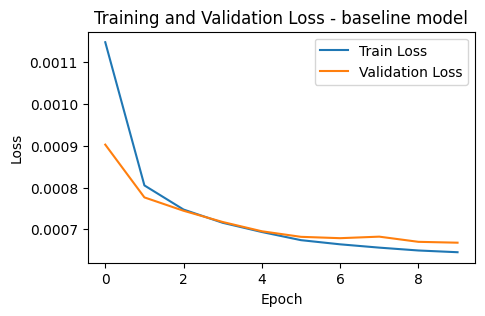

In [21]:
# @title
# Create the plot
plt.figure(figsize=(5,3))
plt.plot(train_losses_org, label='Train Loss')
plt.plot(val_losses_org, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss - baseline model')

# Add legend and show the plot
plt.legend()
plt.show()


#### predict_prob function to get Valid and Test probabilities with the optimized model and return `BinaryLabelDataset` objects.

In [35]:
def predict_prob(model, val_loader, val_data, test_loader, test_data, model_path):
    model.load_state_dict(torch.load(model_path))
    model.eval()

    val_probs = []
    test_probs = []

    with torch.no_grad():
        for inputs, label in val_loader_org:
            outputs = model(inputs)
            val_probs.extend(outputs.squeeze().cpu().numpy())

        for inputs, label in test_loader_org:
            outputs = model(inputs)
            test_probs.append(outputs.squeeze().cpu().numpy())


    valid_pred = val_data.copy(deepcopy=True)
    test_pred = test_data.copy(deepcopy=True)

    valid_pred.scores = np.array(val_probs).reshape(-1, 1)
    test_pred.scores = np.array(test_probs).reshape(-1, 1)

    return valid_pred, test_pred

In [23]:
valid_bld_pred, test_bld_pred = predict_prob(model_baseline, val_loader_org, valid_bld, test_loader_org, test_bld, baseline_model_path)

#### Find the optimal classification threshold for baseline model from the validation set

In [24]:
num_thresh = 100
ba_arr = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):

    valid_bld_pred.labels = (valid_bld_pred.scores >= class_thresh).astype(int)

    classified_metric_orig_valid = ClassificationMetric(valid_bld,
                                             valid_bld_pred,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr[idx] = 0.5*(classified_metric_orig_valid.true_positive_rate()\
                       +classified_metric_orig_valid.true_negative_rate())

best_ind = np.where(ba_arr == np.max(ba_arr))[0][0]
best_class_thresh = class_thresh_arr[best_ind]

print("Best balanced accuracy (no reweighing) = %.4f" % np.max(ba_arr))
print("Optimal classification threshold (no reweighing) = %.4f" % best_class_thresh)

Best balanced accuracy (no reweighing) = 0.8258
Optimal classification threshold (no reweighing) = 0.2872


#### Evaluate accuracy and fairness on test set for each threshold.

In [25]:
test_metrics = {
    'balanced accuracy': [],
    'equal opportunity diff': [],
    'avg odds diff':[]
}

print("Classification threshold used = %.4f" % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    test_bld_pred.labels = (test_bld_pred.scores >= thresh).astype(int)

    metric_test_org = ClassificationMetric(test_bld, test_bld_pred,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

    bal_acc = 0.5*(metric_test_org.true_positive_rate()\
                       +metric_test_org.true_negative_rate())
    eq_opp_diff = metric_test_org.equal_opportunity_difference()
    avg_odd_diff = metric_test_org.average_odds_difference()

    if thresh == best_class_thresh:
        print("\nMetrics using the optimal classification threshold on Test set")
        print("Balanced Accuracy:", bal_acc)
        print("Equal Opportunity difference:", eq_opp_diff)
        print("Average Odds difference:", avg_odd_diff)

    test_metrics['balanced accuracy'].append(bal_acc)
    test_metrics['equal opportunity diff'].append(metric_test_org.equal_opportunity_difference())
    test_metrics['avg odds diff'].append(metric_test_org.average_odds_difference())

Classification threshold used = 0.2872


 42%|████▏     | 42/100 [00:00<00:00, 100.95it/s]


Metrics using the optimal classification threshold on Test set
Balanced Accuracy: 0.8153585911787598
Equal Opportunity difference: -0.1951801459431317
Average Odds difference: -0.2047689578331576


100%|██████████| 100/100 [00:01<00:00, 99.54it/s]


Text(0.5, 1.0, 'Test Set Evaluation')

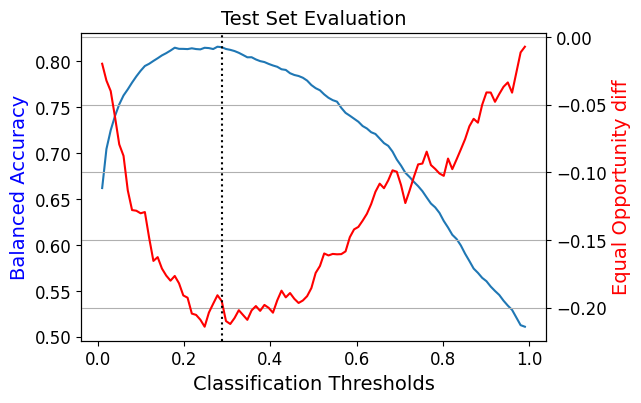

In [26]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics['equal opportunity diff'] , color='r')
ax2.set_ylabel('Equal Opportunity diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation", fontsize=14)

Text(0.5, 1.0, 'Test Set Evaluation')

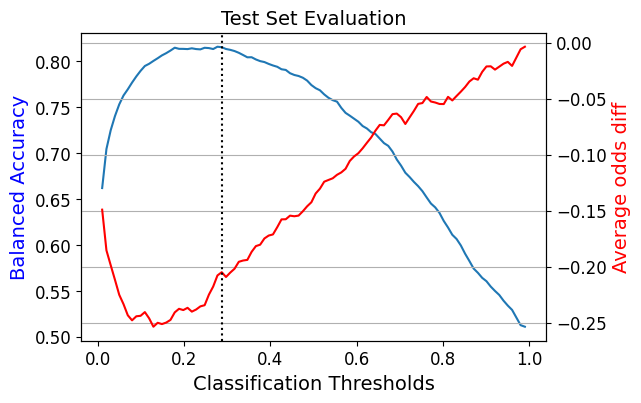

In [27]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics['avg odds diff'] , color='r')
ax2.set_ylabel('Average odds diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation", fontsize=14)

Both metrics showed that the model is biased against unprivileged group at the optimized threshold since they're not in the fairness range.

##  Choose Bias Mitigation Technique:
* Pre-processing: Modify the training data to remove biases before model
training (e.g., reweighing, sampling).
* In-processing: Modify the learning algorithm to reduce bias during model training (e.g., adversarial debiasing).
* Post-processing: Adjust the model’s predictions to reduce bias after training (e.g., equalized odds post-processing).


## 1. Preprocessing: Reweighing

Weights the examples in each (group, label) combination differently to ensure fairness before classification.

- Overall positive class probability: $(P(Y=1))$.
- Positive class probability for each group: $(P(Y=1|G=\text{group}))$.

- For each sample in a group:
    - Positive class weight: $(\frac{P(Y=1)}{P(Y=1|G=\text{group})})$.

    - Negative class weight: $(\frac{1 - P(Y=1)}{1 - P(Y=1|G=\text{group})})$.



In [28]:
from aif360.algorithms.preprocessing.reweighing import Reweighing

# Reweigh trian samples
RW = Reweighing(unprivileged_groups=unprivileged_groups,
               privileged_groups=privileged_groups)
RW.fit(train_bld)
train_bld_rw = RW.transform(train_bld)

# Fit scaler to reweighted train set
scale_rw = MinMaxScaler()
X_train_rw = scale_rw.fit_transform(train_bld_rw.features)
y_train_rw = train_bld_rw.labels.ravel()
w_train_rw = train_bld_rw.instance_weights.ravel()

# Scale validation and test set using new scaler
X_val_rw = scale_rw.transform(valid_bld.features)

X_test_rw = scale_rw.transform(test_bld.features)

Train model using reweighed data.

In [38]:
RW_model_path = 'rw_model_path.pth'
# Set up the loss function and optimizer
model_RW = Net(input_size)
optimizer = torch.optim.Adam(model_RW.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)
num_epochs = 10

train_loader_rw, val_loader_rw, test_loader_rw = load_data(X_train_rw, y_train_rw, X_val_rw, y_val, X_test_rw, y_test, w_train_rw)

train_losses_rw, val_losses_rw = training(model_RW, train_loader_rw, val_loader_rw, num_epochs, optimizer, scheduler, RW_model_path, reweigh=True)

Epoch 1/10 - Train Loss: 0.00114, Val Loss: 0.00090, LR: 0.001
Epoch 2/10 - Train Loss: 0.00081, Val Loss: 0.00079, LR: 0.001
Epoch 3/10 - Train Loss: 0.00075, Val Loss: 0.00076, LR: 0.001
Epoch 4/10 - Train Loss: 0.00072, Val Loss: 0.00075, LR: 0.001
Epoch 5/10 - Train Loss: 0.00070, Val Loss: 0.00073, LR: 0.001
Epoch 6/10 - Train Loss: 0.00068, Val Loss: 0.00072, LR: 0.001
Epoch 7/10 - Train Loss: 0.00068, Val Loss: 0.00071, LR: 0.001
Epoch 8/10 - Train Loss: 0.00067, Val Loss: 0.00070, LR: 0.001
Epoch 9/10 - Train Loss: 0.00066, Val Loss: 0.00069, LR: 0.001
Epoch 10/10 - Train Loss: 0.00065, Val Loss: 0.00069, LR: 0.001


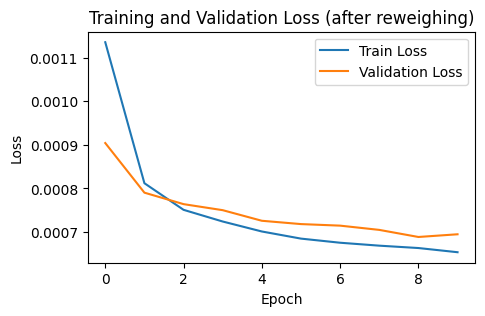

In [39]:
# @title
# Create the plot
plt.figure(figsize=(5,3))
plt.plot(train_losses_rw, label='Train Loss')
plt.plot(val_losses_rw, label='Validation Loss')

# Add labels and title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss (after reweighing)')

# Add legend and show the plot
plt.legend()
plt.show()

Getting Validation and Test probabilities using the reweighed model.

In [40]:
valid_pred_rw, test_pred_rw = predict_prob(model_RW, val_loader_rw, valid_bld, test_loader_rw, test_bld, RW_model_path)

Find new optimal threshold using validation set for reweigh model.

In [41]:
num_thresh = 100
ba_arr_rw = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):

    valid_pred_rw.labels = (valid_pred_rw.scores >= class_thresh).astype(int)

    classified_metric_valid_rw = ClassificationMetric(valid_bld,
                                             valid_pred_rw,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr_rw[idx] = 0.5*(classified_metric_valid_rw.true_positive_rate()\
                       +classified_metric_valid_rw.true_negative_rate())

best_ind_rw = np.where(ba_arr_rw == np.max(ba_arr_rw))[0][0]
best_class_thresh_rw = class_thresh_arr[best_ind_rw]

print("Best balanced accuracy (reweighing) = %.4f" % np.max(ba_arr_rw))
print("Optimal classification threshold (reweighing) = %.4f" % best_class_thresh_rw)

Best balanced accuracy (reweighing) = 0.8168
Optimal classification threshold (reweighing) = 0.2278


Evaluation results of test set using reweigh model on different threshold.

In [61]:
test_metrics_rw = {
    'balanced accuracy': [],
    'equal opportunity diff': [],
    'avg odds diff':[]
}

print("Classification threshold used = %.4f" % best_class_thresh_rw)

for thresh in tqdm(class_thresh_arr):
    test_pred_rw.labels = (test_pred_rw.scores >= thresh).astype(int)

    metric_test_rw = ClassificationMetric(test_bld, test_pred_rw,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

    bal_acc = 0.5*(metric_test_rw.true_positive_rate()\
                       +metric_test_rw.true_negative_rate())
    eq_opp_diff = metric_test_rw.equal_opportunity_difference()
    avg_odd_diff = metric_test_rw.average_odds_difference()

    if thresh == best_class_thresh_rw:
        print(f"\nMetrics using the new optimal classification threshold = {best_class_thresh_rw:.4f} on Test set")
        print("Balanced Accuracy:", bal_acc)
        print("Equal Opportunity difference:", eq_opp_diff)
        print("Average Odds difference:", avg_odd_diff)

    if thresh == best_class_thresh:
        print(f"\nMetrics using the initial optimal classification threshold = {best_class_thresh:.4f} on Test set")
        print("Balanced Accuracy:", bal_acc)
        print("Equal Opportunity difference:", eq_opp_diff)
        print("Average Odds difference:", avg_odd_diff)

    test_metrics_rw['balanced accuracy'].append(bal_acc)
    test_metrics_rw['equal opportunity diff'].append(metric_test_rw.equal_opportunity_difference())
    test_metrics_rw['avg odds diff'].append(metric_test_rw.average_odds_difference())


Classification threshold used = 0.2278


 27%|██▋       | 27/100 [00:00<00:02, 30.67it/s]


Metrics using the new optimal classification threshold = 0.2278 on Test set
Balanced Accuracy: 0.8069334170330082
Equal Opportunity difference: 0.0259674091892389
Average Odds difference: -0.0315799810263683


 34%|███▍      | 34/100 [00:01<00:02, 29.12it/s]


Metrics using the initial optimal classification threshold = 0.2872 on Test set
Balanced Accuracy: 0.8065693677372253
Equal Opportunity difference: 0.05118867646117142
Average Odds difference: -0.0007364752769298544


100%|██████████| 100/100 [00:01<00:00, 50.03it/s]


Text(0.5, 1.0, 'Test Set Evaluation (Reweighing)')

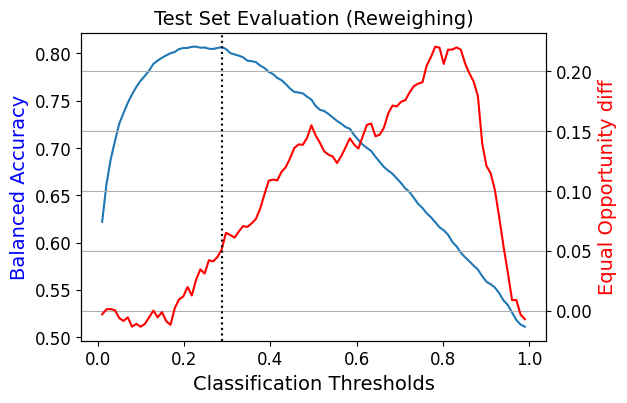

In [63]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics_rw['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics_rw['equal opportunity diff'] , color='r')
ax2.set_ylabel('Equal Opportunity diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation (Reweighing)",fontsize=14)

Text(0.5, 1.0, 'Test Set Evaluation (Reweighing)')

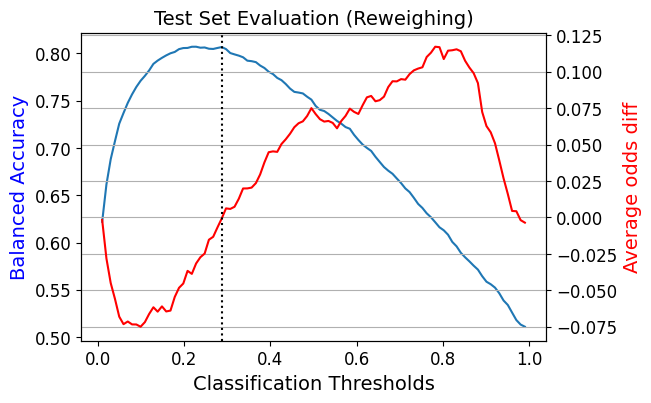

In [64]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics_rw['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics_rw['avg odds diff'] , color='r')
ax2.set_ylabel('Average odds diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation (Reweighing)",fontsize=14)

The reweighing approach was successful to mitigate bias according to both metrics. The value of both metrics is now in fairness range at new optimal classification threshold.

## 2. Post-processing: Calibrated Equal Odds Prediction

This technique has to aims:
1. **Equal Odds**: The model should have similar accuracy for both positive and negative classes across privileged and unprivileged groups. This means equalizing the false positive rates (FPR) and/or true positive rates (TPR) across these groups.

2. **Calibration**: The predicted probabilities should accurately reflect the true likelihood of the positive class. For example, if a model predicts a probability of 0.7 for that event, then approximately 70% of those predictions should be correct.

In [93]:
# Odds equalizing post-processing algorithm
from aif360.algorithms.postprocessing.calibrated_eq_odds_postprocessing import CalibratedEqOddsPostprocessing
cost_constraint = "fnr" # "fnr", "fpr", "weighted"  FNR = 1 - TPR
#random seed for calibrated equal odds prediction
randseed = 42
# Learn parameters to equalize odds and apply to create a new dataset
CEO = CalibratedEqOddsPostprocessing(privileged_groups = privileged_groups,
                                     unprivileged_groups = unprivileged_groups,
                                     cost_constraint=cost_constraint,
                                     seed=randseed)
CEO = CEO.fit(valid_bld, valid_bld_pred)

In [94]:
valid_pred_ceo = CEO.predict(valid_bld_pred)
test_pred_ceo = CEO.predict(test_bld_pred)

In [95]:
num_thresh = 100
ba_arr_ceo = np.zeros(num_thresh)
class_thresh_arr = np.linspace(0.01, 0.99, num_thresh)

for idx, class_thresh in enumerate(class_thresh_arr):

    valid_pred_ceo.labels = (valid_pred_ceo.scores >= class_thresh).astype(int)

    classified_metric_valid_ceo = ClassificationMetric(valid_bld,
                                             valid_pred_ceo,
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)

    ba_arr_ceo[idx] = 0.5*(classified_metric_valid_ceo.true_positive_rate()\
                       +classified_metric_valid_ceo.true_negative_rate())

best_ind_ceo = np.where(ba_arr_ceo == np.max(ba_arr_ceo))[0][0]
best_class_thresh_ceo = class_thresh_arr[best_ind_ceo]

print("Best balanced accuracy (Calibrated Equalized Odds) = %.4f" % np.max(ba_arr_ceo))
print("Optimal classification threshold (Calibrated Equalized Odds) = %.4f" % best_class_thresh_ceo)

Best balanced accuracy (Calibrated Equalized Odds) = 0.7595
Optimal classification threshold (Calibrated Equalized Odds) = 0.2674


In [96]:
test_metrics_ceo = {
    'balanced accuracy': [],
    'equal opportunity diff': [],
    'avg odds diff':[]
}

print("Classification threshold used = %.4f" % best_class_thresh)

for thresh in tqdm(class_thresh_arr):
    test_pred_ceo.labels = (test_pred_ceo.scores >= thresh).astype(int)

    metric_test_ceo = ClassificationMetric(test_bld, test_pred_ceo,
                             unprivileged_groups=unprivileged_groups,
                             privileged_groups=privileged_groups)

    bal_acc = 0.5*(metric_test_ceo.true_positive_rate()\
                       +metric_test_ceo.true_negative_rate())
    eq_opp_diff = metric_test_ceo.equal_opportunity_difference()
    avg_odd_diff = metric_test_ceo.average_odds_difference()

    if thresh == best_class_thresh_ceo:
        print(f"\nMetrics using the new optimal classification threshold = {best_class_thresh_ceo:.4f} on Test set")
        print("Balanced Accuracy:", bal_acc)
        print("Equal Opportunity difference:", eq_opp_diff)
        print("Average Odds difference:", avg_odd_diff)

    if thresh == best_class_thresh:
        print(f"\nMetrics using the initial optimal classification threshold = {best_class_thresh:.4f} on Test set")
        print("Balanced Accuracy:", bal_acc)
        print("Equal Opportunity difference:", eq_opp_diff)
        print("Average Odds difference:", avg_odd_diff)

    test_metrics_ceo['balanced accuracy'].append(bal_acc)
    test_metrics_ceo['equal opportunity diff'].append(metric_test_ceo.equal_opportunity_difference())
    test_metrics_ceo['avg odds diff'].append(metric_test_ceo.average_odds_difference())

Classification threshold used = 0.2872


 17%|█▋        | 17/100 [00:00<00:00, 166.29it/s]


Metrics using the new optimal classification threshold = 0.2674 on Test set
Balanced Accuracy: 0.743981618861425
Equal Opportunity difference: -0.24122935233211118
Average Odds difference: -0.3823883394644965

Metrics using the initial optimal classification threshold = 0.2872 on Test set
Balanced Accuracy: 0.7439239257602843
Equal Opportunity difference: -0.2426993632736698
Average Odds difference: -0.37703555506259434


100%|██████████| 100/100 [00:02<00:00, 49.53it/s]


Text(0.5, 1.0, 'Test Set Evaluation (Calibrated Eq Odds)')

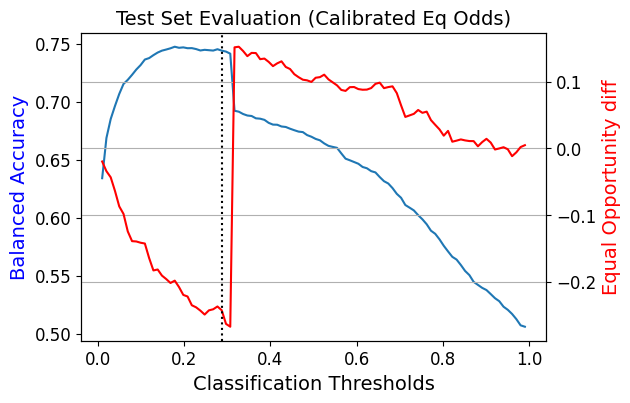

In [97]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics_ceo['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics_ceo['equal opportunity diff'] , color='r')
ax2.set_ylabel('Equal Opportunity diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh, color='k', linestyle=':')
# ax2.axvline(best_class_thresh_ceo, color='green', linestyle='-.')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation (Calibrated Eq Odds)", fontsize=14)

Text(0.5, 1.0, 'Test Set Evaluation  (Calibrated Eq Odds)')

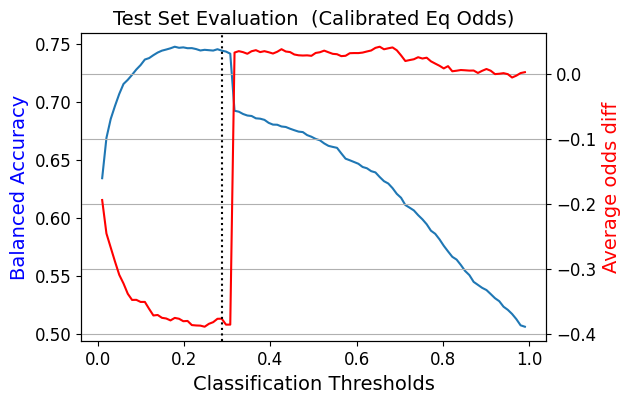

In [98]:
# @title
# Display results for all thresholds
fig, ax1 = plt.subplots(figsize=(6,4))
ax1.plot(class_thresh_arr, test_metrics_ceo['balanced accuracy'])
ax1.set_xlabel('Classification Thresholds', fontsize=14)
ax1.set_ylabel('Balanced Accuracy', color='b', fontsize=14)
ax1.xaxis.set_tick_params(labelsize=12)
ax1.yaxis.set_tick_params(labelsize=12)


ax2 = ax1.twinx()
ax2.plot(class_thresh_arr, test_metrics_ceo['avg odds diff'] , color='r')
ax2.set_ylabel('Average odds diff', color='r', fontsize=14)
ax2.axvline(best_class_thresh, color='k', linestyle=':')
ax2.yaxis.set_tick_params(labelsize=12)
ax2.grid(True)
plt.title("Test Set Evaluation  (Calibrated Eq Odds)", fontsize=14)

### Troubleshooting
ideas to understand why Calibrated Equalized Odds wasn't effective.

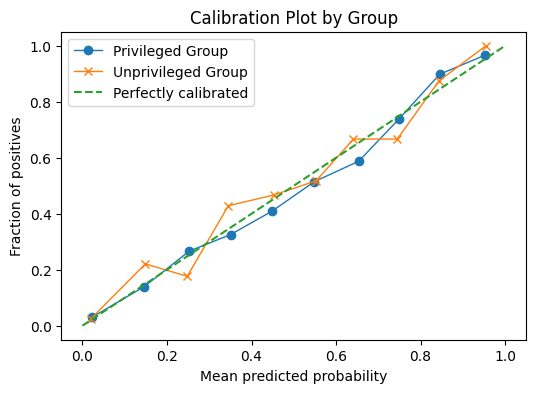

In [103]:
# @title
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Split the data into privileged and unprivileged groups
privileged_indices = test_bld.protected_attributes[:, 0] == 1  # Adjust the index based on your protected attribute
unprivileged_indices = test_bld.protected_attributes[:, 0] == 0

y_true_priv = test_bld.labels[privileged_indices]
y_pred_priv = test_bld_pred.scores[privileged_indices]

y_true_unpriv = test_bld.labels[unprivileged_indices]
y_pred_unpriv = test_bld_pred.scores[unprivileged_indices]

# Compute calibration curves for each group
prob_true_priv, prob_pred_priv = calibration_curve(y_true_priv, y_pred_priv, n_bins=10)
prob_true_unpriv, prob_pred_unpriv = calibration_curve(y_true_unpriv, y_pred_unpriv, n_bins=10)
plt.figure(figsize=(6, 4))

# Plot calibration curves
plt.plot(prob_pred_priv, prob_true_priv, marker='o', linewidth=1, label='Privileged Group')
plt.plot(prob_pred_unpriv, prob_true_unpriv, marker='x', linewidth=1, label='Unprivileged Group')
plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')

plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.legend()
plt.title('Calibration Plot by Group')
plt.show()


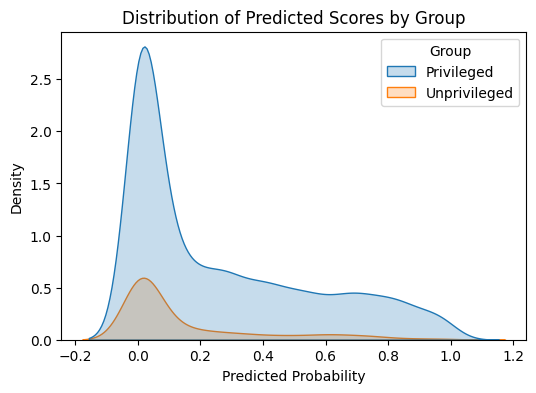

In [104]:
# @title
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_priv = y_pred_priv.flatten()
y_pred_unpriv = y_pred_unpriv.flatten()

# Now concatenate them and create the DataFrame
df_scores = pd.DataFrame({
    'Score': np.concatenate([y_pred_priv, y_pred_unpriv]),
    'Group': ['Privileged']*len(y_pred_priv) + ['Unprivileged']*len(y_pred_unpriv)
})

# Plot the distribution of scores
plt.figure(figsize=(6,4))
sns.kdeplot(data=df_scores, x='Score', hue='Group', fill=True)
plt.title('Distribution of Predicted Scores by Group')
plt.xlabel('Predicted Probability')
plt.ylabel('Density')
plt.show()


## Summary

In [99]:
# @title
data = {
    'Model': ['Initial', 'Aft. Reweighing', 'Aft. Calibrate Equalized Odds'],
    'Balanced Accuracy': [0.815, 0.806, 0.743],
    'Equal Opportunity Difference': [-0.195, 0.0511, -0.242],
    'Average Odds Difference': [-0.204, -0.0007, -0.377]
}

results_df = pd.DataFrame(data)

results_df.head()

,Model,Balanced Accuracy,Equal Opportunity Difference,Average Odds Difference
0,Initial,0.815,-0.1950,-0.2040
1,Aft. Reweighing,0.806,0.0511,-0.0007
2,Aft. Calibrate Equalized Odds,0.743,-0.2420,-0.3770


we can notice that Reweighing preprocessing algorithm was successful in mitigating the bias and satisfying the fairness constraints we chose. However, Calibrated Equalized Odds not only reduced the balanced accuracy but also made the predictions more biased according to the fairness metrics.

If possible, all algorithms from all permissible categories should be tested because the ultimate performance depends on dataset characteristics: **there is no one best algorithm independent of dataset **!

### Exercise
Try Adversial Debiasing (in-processing) algorithm and compare its effectiveness to these two models.